In [24]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanAbsoluteError
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

# Load and preprocess image
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = image.resize((2048, 64))  # Resize to desired dimensions (width=2048, height=64)
    image = np.array(image) / 127.5 - 1  # Normalize to [-1, 1]
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    return image

# Load dataset
def load_dataset(comp_dir, lg_dir):
    comp_images = []
    lg_images = []

    comp_filenames = sorted(os.listdir(comp_dir))
    lg_filenames = sorted(os.listdir(lg_dir))

    for comp_file, lg_file in zip(comp_filenames, lg_filenames):
        comp_image = load_and_preprocess_image(os.path.join(comp_dir, comp_file))
        lg_image = load_and_preprocess_image(os.path.join(lg_dir, lg_file))

        comp_images.append(comp_image)
        lg_images.append(lg_image)

    comp_images = np.array(comp_images)
    lg_images = np.array(lg_images)

    return comp_images, lg_images

# Cosine schedule
def cosine_schedule(num_steps, s=0.008):
    steps = np.arange(num_steps + 1)
    alpha_bar = np.cos(((steps / num_steps) + s) / (1 + s) * np.pi / 2) ** 2
    noise_levels = 1.0 - alpha_bar / alpha_bar[0]
    return noise_levels


In [25]:
# Load the VGG19 model pretrained on ImageNet
vgg = VGG19(weights='imagenet', include_top=False)

# Select specific layers for perceptual loss computation
layer_names = ['block1_conv2', 'block2_conv2', 'block3_conv2', 'block4_conv2']
outputs = [vgg.get_layer(name).output for name in layer_names]

# Create a model that outputs these selected layers
vgg_model = Model(inputs=vgg.input, outputs=outputs)
vgg_model.trainable = False  # Freeze the VGG model

# Define the mean absolute error loss
mae_loss = MeanAbsoluteError()

def perceptual_loss(y_true, y_pred):
    # Convert grayscale images to 3-channel by duplicating the channel 3 times
    y_true_rgb = tf.image.grayscale_to_rgb(y_true)
    y_pred_rgb = tf.image.grayscale_to_rgb(y_pred)

    # Compute VGG features for both true and predicted images
    y_true_features = vgg_model(y_true_rgb)
    y_pred_features = vgg_model(y_pred_rgb)

    # Compute perceptual loss as the mean absolute error between feature maps
    loss = 0.0
    for true_feat, pred_feat in zip(y_true_features, y_pred_features):
        loss += mae_loss(true_feat, pred_feat)
    
    return loss


In [26]:
class DiffusionModel(Model):
    def __init__(self, input_shape):
        super(DiffusionModel, self).__init__()
        self.unet = self.build_unet(input_shape)
        self.input_shape_ = input_shape
        self.dummy_noisy_input = tf.keras.layers.Input(shape=input_shape)
        self.dummy_condition_input = tf.keras.layers.Input(shape=input_shape)
        self.call([self.dummy_noisy_input, self.dummy_condition_input])  # This builds the model

    def build_unet(self, input_shape):
        def conv_block(x, filters, kernel_size=3, strides=1, padding='same'):
            x = layers.Conv2D(filters, kernel_size, strides, padding)(x)
            x = layers.BatchNormalization()(x)
            x = layers.ReLU()(x)
            return x

        inputs = layers.Input(shape=input_shape)
        condition = layers.Input(shape=input_shape)  # Condition image

        x = layers.Concatenate()([inputs, condition])

        # Encoder
        skips = []
        for filters in [64, 128, 256, 512]:
            x = conv_block(x, filters)
            skips.append(x)
            x = layers.MaxPooling2D()(x)

        # Bottleneck
        x = conv_block(x, 1024)

        # Decoder
        for filters, skip in zip([512, 256, 128, 64], reversed(skips)):
            x = layers.UpSampling2D()(x)
            x = layers.Concatenate()([x, skip])
            x = conv_block(x, filters)

        outputs = layers.Conv2D(1, kernel_size=1, activation='tanh')(x)
        return Model([inputs, condition], outputs)

    def call(self, inputs):
        noisy_images, condition_images = inputs
        return self.unet([noisy_images, condition_images])

    def train_step(self, data):
        images, condition_images = data
        noise_level = tf.random.uniform(shape=(), minval=0.1, maxval=1.0, dtype=tf.float32)
        noisy_images, noise = self.add_noise(images, noise_level)

        with tf.GradientTape() as tape:
            predicted_noise = self([noisy_images, condition_images], training=True)
            l1_loss = tf.reduce_mean(tf.abs(noise - predicted_noise))

            # Compute perceptual loss
            generated_images = noisy_images - predicted_noise
            perc_loss = perceptual_loss(images, generated_images)

            # Combine L1 loss and perceptual loss
            total_loss = l1_loss + perc_loss

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": total_loss}

    def add_noise(self, images, noise_level):
        images = tf.cast(images, tf.float32)  # Ensure images are float32
        noise_level = tf.cast(noise_level, tf.float32)  # Ensure noise_level is float32
        noise = tf.random.normal(shape=tf.shape(images), dtype=tf.float32) * noise_level
        noisy_images = images + noise
        return noisy_images, noise


In [28]:
input_shape = (64, 2048, 1)
model = DiffusionModel(input_shape)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

comp_images, lg_images = load_dataset('/Selected_Comp', '/Selected_LG')

# Create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((lg_images, comp_images))
dataset = dataset.batch(8)


Model: "diffusion_model_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_11 (Functional)      │ (None, 64, 2048, 1)    │    15,683,137 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,683,137 (59.83 MB)

 Trainable params: 15,677,249 (59.80 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [32]:
# Train the model
model.fit(dataset, epochs=100)

Epoch 1/100
 18/125 ━━━━━━━━━━━━━━━━━━━━ 59:39 33s/step - loss: 15.4564  

KeyboardInterrupt: 

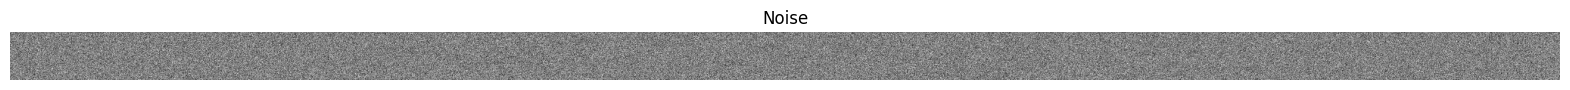

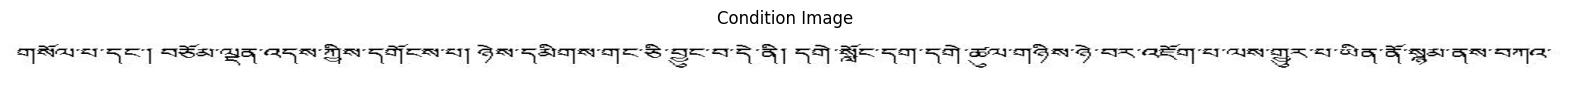

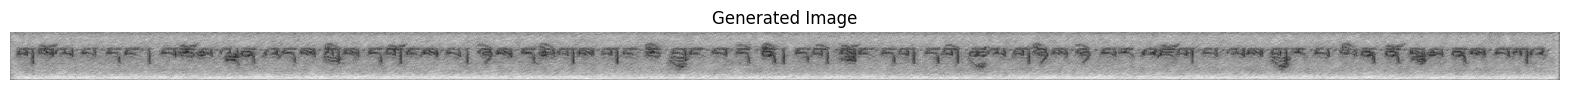

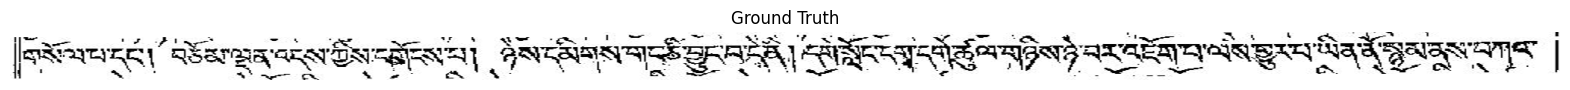

In [31]:
def generate_and_print_image(model, dataset, noise_level):
    # Take a single sample from the dataset
    for images, condition_images in dataset.take(1):
        break

    # Select the first image and condition image from the batch
    image = images[0:1]
    condition_image = condition_images[0:1]

    condition_image = tf.cast(condition_image, tf.float32)  # Ensure condition_images are float32
    noise_level = tf.cast(noise_level, tf.float32)  # Ensure noise_level is float32
    noisy_image, noise = model.add_noise(condition_image, noise_level)
    generated_image = model([noisy_image, condition_image])

    # Visualize the results
    def plot_single_image(title, image):
        plt.figure(figsize=(20, 5))
        plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis("off")
        plt.show()

    plot_single_image("Noise", noise.numpy().squeeze())
    plot_single_image("Condition Image", condition_image.numpy().squeeze())
    plot_single_image("Generated Image", generated_image.numpy().squeeze())
    plot_single_image("Ground Truth", image.numpy().squeeze())

# Example for generating and printing new image using a sample from the training data
noise_level = 0.5  # Choose a noise level
generate_and_print_image(model, dataset, noise_level)


In [33]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [35]:
!nvidia-smi

Sun Jul 14 06:09:51 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40S                    On  |   00000000:61:00.0 Off |                    0 |
| N/A   29C    P8             32W /  350W |       3MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [36]:
pip install tensorflow-gpu

  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      Traceback (most recent call last):
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/_parser.py", line 126, in _parse_requirement_details
          marker = _parse_requirement_marker(
        File 

In [37]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


TensorFlow version: 2.17.0
Num GPUs Available:  0


In [39]:
!nvidia-smi

Sun Jul 14 06:11:43 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40S                    On  |   00000000:61:00.0 Off |                    0 |
| N/A   29C    P8             32W /  350W |       3MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [42]:
!export PATH=/usr/local/cuda/bin${PATH:+:${PATH}}
!export LD_LIBRARY_PATH=/usr/local/cuda/lib64${LD_LIBRARY_PATH:+:${LD_LIBRARY_PATH}}

In [47]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


TensorFlow version: 2.17.0
Num GPUs Available:  0


In [49]:
!nvcc --version

/bin/bash: line 1: nvcc: command not found
